# Install dependecies

In [1]:
!pip install tensorflow==2.4.1 opencv-python matplotlib

You should consider upgrading via the '/Users/sanjeev/Documents/faceid/faceid/bin/python3 -m pip install --upgrade pip' command.


# Import dependencies

In [1]:
#standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#tensorflow dependencies- Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# create folder structure

In [3]:
#Setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [5]:
#making directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# collect positive and anchor images

In [6]:
#uncompress tar gz labelled faces in the wild dataset
!tar -xf lfw.tgz

In [10]:
#Move lfw images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'lfw'

In [4]:
#import uuid to generate unique image names
import uuid

In [10]:
#establish a connection to the webcame
cap = cv2.VideoCapture(0)
while cap.isOpened(): #loop through frames till the webcam is open
    ret,frame = cap.read() #read frames at every point in time
    
    frame = frame[130:130+250,530:530+250,:] #cut down frame to 250 X 250
    
    if cv2.waitKey(1) & 0XFF == ord('a'): #collecting anchor images
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) #create the unique file path
        cv2.imwrite(imgname, frame) #write out anchor image
        
    if cv2.waitKey(1) & 0XFF == ord('p'): #collecting positive images
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame) #rendering the frame back to the screen
    
    if cv2.waitKey(1) & 0XFF == ord('q'): #breaking
        break
        
cap.release() #release the webcam
cv2.destroyAllWindows() #close the image show frame

# load and preprocess images

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2022-05-08 03:23:41.650423: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-08 03:23:41.666660: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
dir_test.next()

b'data/anchor/0dedf862-cc9e-11ec-8297-1094bbdfb49c.jpg'

In [9]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) #read in image from file path
    img = tf.io.decode_jpeg(byte_img) #load in the image
    img = tf.image.resize(img,(100,100)) #resizing image to 100 X 100 X 3
    img = img / 255.0 #scaling the image between 0 and 1
    return img

In [10]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [12]:
samples = data.as_numpy_iterator()

In [13]:
example = samples.next()

In [14]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [15]:
res = preprocess_twin(*example)

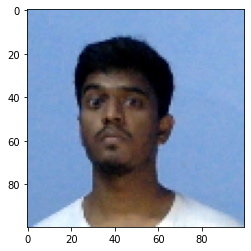

In [16]:
plt.imshow(res[0])

In [17]:
res[2]

1.0

In [18]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [19]:
samples = data.as_numpy_iterator()

In [20]:
len(samples.next())

2022-05-08 03:24:11.661411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


3

In [21]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# model engineering

In [23]:
inp = Input(shape=(100,100,3),name='input_image')

In [24]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [25]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)

In [26]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [30]:
m1 = MaxPooling2D(64,(2,2),padding='same')(c1)


In [31]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [33]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    
    #first block
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    
    #second block
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    #third block
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    
    #final embedding block
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation='sigmoid')(f1)
    
    
    
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [34]:
embedding = make_embedding()

In [36]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0 

In [37]:
#Siamese L1 distance class
class L1Dist(Layer):
    
    #init method - inheritance
    def __init__(self,**kwargs):
        super().__init__()
        
    # similarity calculation    
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [41]:
def make_siamese_model():
    
    #anchor image input
    input_image = Input(name = 'imput_img', shape = (100,100,3))
    
    #validation image input
    validation_image = Input(name = 'validation_img',shape=(100,100,3))
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    #classification layer
    classifier = Dense(1,activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image,validation_image],outputs= classifier,name = 'SiameseNetwork')

In [42]:
siamese_model = make_siamese_model()

In [43]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imput_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    imput_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     